# Sequential Training Pipeline

Train models sequentially across multiple days:
- **Dataset**: TOTF
- **Scaler**: Box-Cox
- **Models**: Transformer+OCSVM, PRAE, PNN
- **Training Strategy**: Train on first hour of each day (5-min blocks), test on rest of day
- **Final Test**: Final Day (25) (morning + rest of day)

In [1]:
import os
import torch
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from PDMM import preprocessing as prep
from PDMM import  machine_learning as ml
from PDMM import visualization as viz
from PDMM.pipeline import AnomalyDetectionPipeline, sequential_training_pipeline

os.makedirs('../models', exist_ok=True)

## Configuration

In [ ]:
# Data Configuration
DATA_DIR = '../data/TOTF.PA-book'  # Directory with daily TOTF files
SCALER_TYPE = 'box-cox'

# Sequential Training Parameters
NUM_DAYS = 24            # Train on first 24 days
FIRST_HOUR_MINUTES = 60  # Use first hour of each day
TRAIN_BLOCK_MINUTES = 5  # 5-minute training blocks
VAL_BLOCK_MINUTES = 5    # 5-minute validation blocks

# Model Hyperparameters
SEQ_LENGTH = 25
BATCH_SIZE = 128
EPOCHS = 1000
HIDDEN_DIM = 64
LR = 1e-3
PATIENCE = 5

# Model Types to Train
MODELS = ['transformer_ocsvm', 'prae', 'pnn']

# Feature Sets
FEATURE_SETS = ['base', 'tao', 'poutre', 'hawkes', 'ofi']

## Check Available Data Files

In [3]:
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(('.csv', '.csv.gz', '.parquet'))])
print(f"Found {len(files)} data files in {DATA_DIR}")

Found 25 data files in ../data/TOTF.PA-book


## Train Models Sequentially

Train each model type on 30 days, evaluate on rest of each day + Day 31

### 1. Transformer + OC-SVM

In [4]:
print("TRAINING: Transformer + OC-SVM")

results_transformer, pipeline_transformer = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='transformer_ocsvm',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    nu=0.01,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_transformer_ocsvm_results.json', 'w') as f:
    json.dump(results_transformer, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_transformer_ocsvm_sequential"
torch.save(pipeline_transformer.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_transformer.scaler, f"{base_filename}_scaler.pkl")
if pipeline_transformer.detector is not None:
    joblib.dump(pipeline_transformer.detector, f"{base_filename}_ocsvm_detector.pkl")
    joblib.dump(pipeline_transformer.latent_scaler, f"{base_filename}_latent_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'transformer_ocsvm',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_transformer.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_transformer.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved Transformer+OCSVM model to {base_filename}")

TRAINING: Transformer + OC-SVM
Pipeline initialized on device: cuda
Starting sequential training on 2 days...
Train block: 5 min, Val block: 5 min
Day 1/2: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Initializing transformer_ocsvm model...
Initializing Transformer Autoencoder...
Training Autoencoder (Max Epochs=1000).

### 2. Probabilistic Robust Autoencoder (PRAE)

In [5]:
print("TRAINING: PRAE")

results_prae, pipeline_prae = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='prae',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    lambda_reg=0.1,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_prae_results.json', 'w') as f:
    json.dump(results_prae, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_prae_sequential"
torch.save(pipeline_prae.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_prae.scaler, f"{base_filename}_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'prae',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_prae.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_prae.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved PRAE model to {base_filename}")

TRAINING: PRAE
Pipeline initialized on device: cuda
Starting sequential training on 2 days...
Train block: 5 min, Val block: 5 min
Day 1/2: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Initializing prae model...
Initializing Probabilistic Robust Autoencoder (PRAE)...
Training PRAE (lambda=0.100000, Max Epochs=1000)...


### 3. Probabilistic Neural Network (PNN)

In [6]:
print("TRAINING: PNN")

results_pnn, pipeline_pnn = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='pnn',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_pnn_results.json', 'w') as f:
    json.dump(results_pnn, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_pnn_sequential"
torch.save(pipeline_pnn.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_pnn.scaler, f"{base_filename}_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'pnn',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_pnn.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_pnn.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved PNN model to {base_filename}")

TRAINING: PNN
Pipeline initialized on device: cuda
Starting sequential training on 2 days...
Train block: 5 min, Val block: 5 min
Day 1/2: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Initializing pnn model...
Initializing Probabilistic Neural Network (PNN)...
Training PNN (Max Epochs=1000)...
Epoch 1/1000 - Train: 1.3

## Visualize Results

### Transformer + OC-SVM Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_transformer_ocsvm_results.png


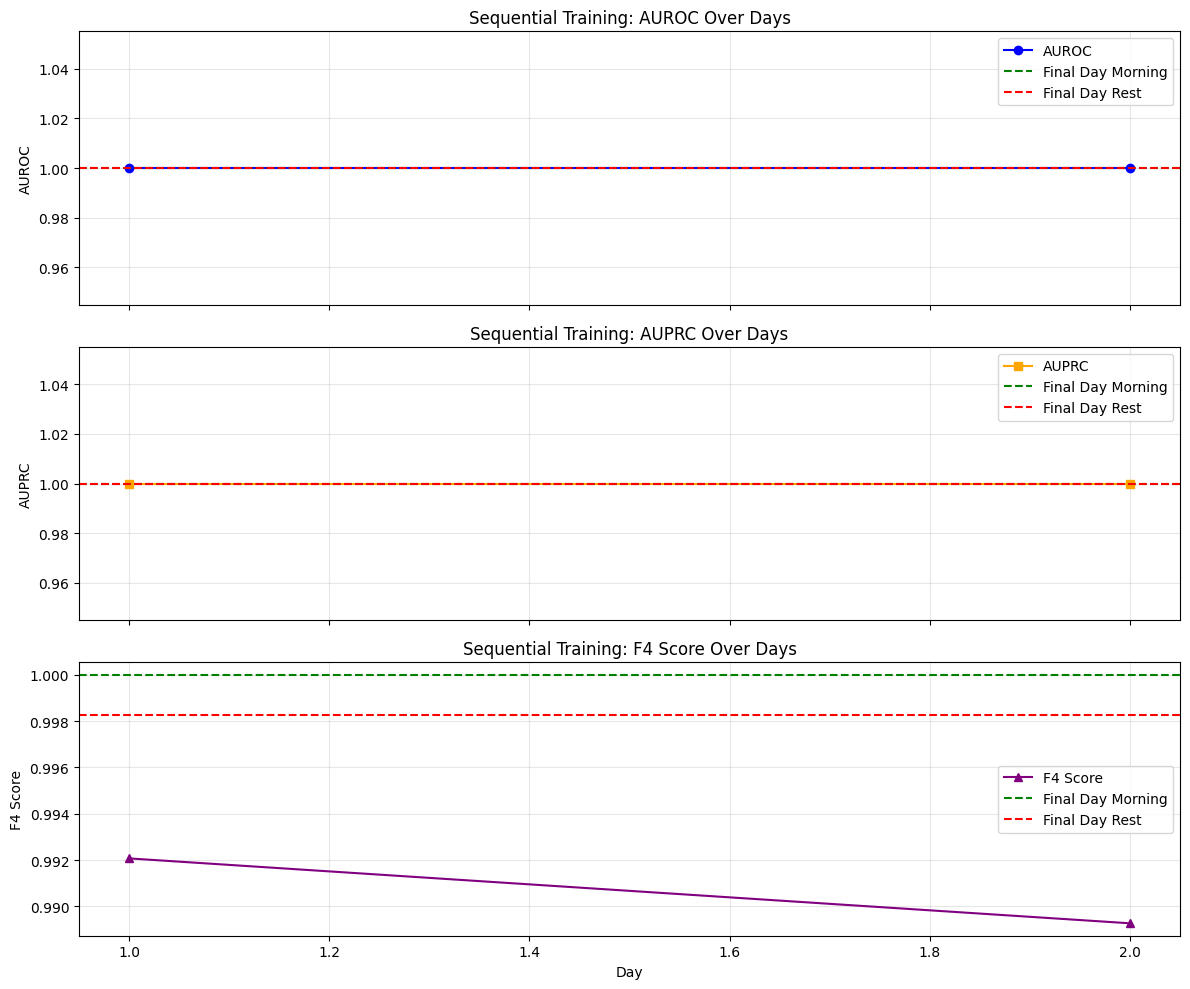

In [7]:
viz.plot_sequential_results(results_transformer, save_path='../results/training/figures/TOTF_sequential_transformer_ocsvm_results.png')

### PRAE Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_prae_results.png


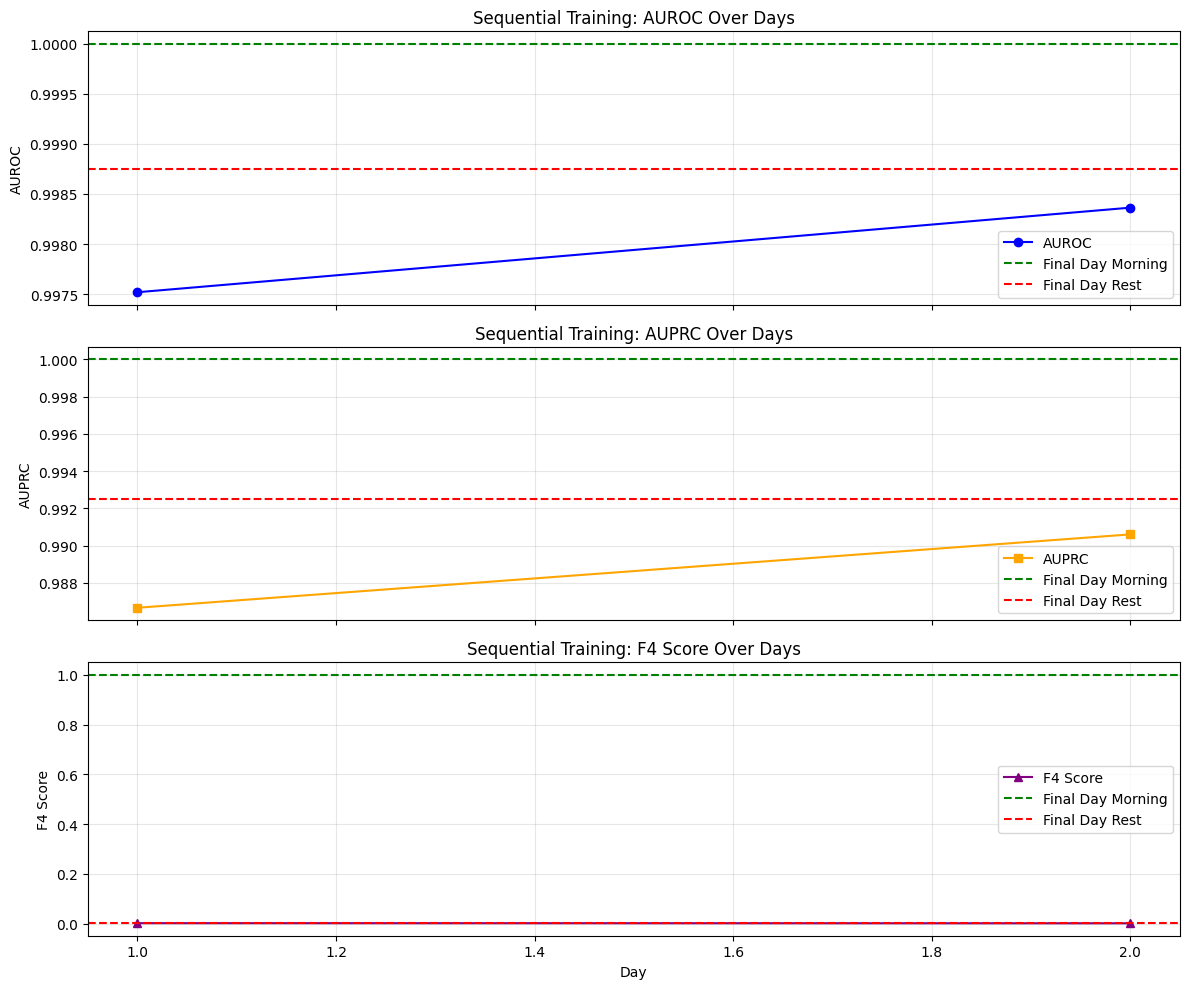

In [8]:
viz.plot_sequential_results(results_prae, save_path='../results/training/figures/TOTF_sequential_prae_results.png')

### PNN Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_pnn_results.png


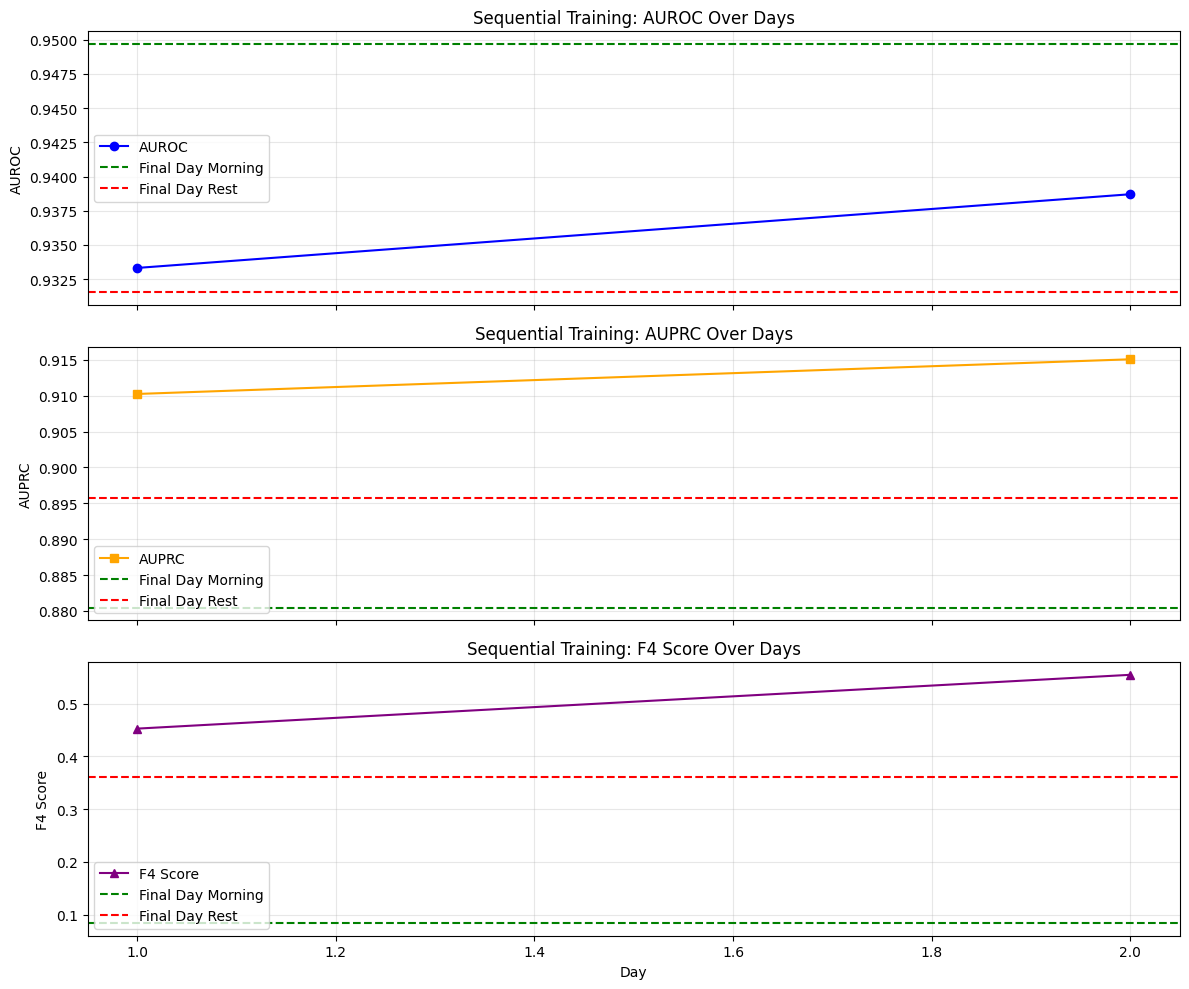

In [9]:
viz.plot_sequential_results(results_pnn, save_path='../results/training/figures/TOTF_sequential_pnn_results.png')

## Compare All Models

In [10]:
# Create comparison DataFrame
comparison_data = []

for model_name, results in [('Transformer+OCSVM', results_transformer), 
                             ('PRAE', results_prae), 
                             ('PNN', results_pnn)]:
    
    # Average over all training days
    daily_df = pd.DataFrame(results['daily_metrics'])
    avg_metrics = {
        'Model': model_name,
        'Avg_AUROC': daily_df['AUROC'].mean(),
        'Avg_AUPRC': daily_df['AUPRC'].mean(),
        'Avg_F4': daily_df['F4_Score'].mean(),
    }
    
    # Final Day Morning
    if results['final_day_morning_metrics']:
        avg_metrics['FinalDay_Morning_AUROC'] = results['final_day_morning_metrics']['AUROC']
        avg_metrics['FinalDay_Morning_AUPRC'] = results['final_day_morning_metrics']['AUPRC']
        avg_metrics['FinalDay_Morning_F4'] = results['final_day_morning_metrics']['F4_Score']
    
    # Final Day Rest
    if results['final_day_rest_metrics']:
        avg_metrics['FinalDay_Rest_AUROC'] = results['final_day_rest_metrics']['AUROC']
        avg_metrics['FinalDay_Rest_AUPRC'] = results['final_day_rest_metrics']['AUPRC']
        avg_metrics['FinalDay_Rest_F4'] = results['final_day_rest_metrics']['F4_Score']
    
    comparison_data.append(avg_metrics)

comparison_df = pd.DataFrame(comparison_data)
print("MODEL COMPARISON - Sequential Training")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('../results/training/TOTF_sequential_model_comparison.csv', index=False)
print("\nSaved comparison to ../results/training/TOTF_sequential_model_comparison.csv")

MODEL COMPARISON - Sequential Training
            Model  Avg_AUROC  Avg_AUPRC   Avg_F4  FinalDay_Morning_AUROC  FinalDay_Morning_AUPRC  FinalDay_Morning_F4  FinalDay_Rest_AUROC  FinalDay_Rest_AUPRC  FinalDay_Rest_F4
Transformer+OCSVM   1.000000   1.000000 0.990671                  1.0000                1.000000             1.000000             1.000000             1.000000          0.998275
             PRAE   0.997941   0.988637 0.001994                  1.0000                1.000000             1.000000             0.998744             0.992478          0.001336
              PNN   0.936012   0.912652 0.503696                  0.9497                0.880434             0.083655             0.931543             0.895671          0.361760

Saved comparison to ../results/training/TOTF_sequential_model_comparison.csv


## Summary Statistics

In [11]:
print("SEQUENTIAL TRAINING SUMMARY")
print(f"Dataset: TOTF")
print(f"Scaler: {SCALER_TYPE}")
print(f"Training Days: {NUM_DAYS}")
print(f"Training Strategy: First {FIRST_HOUR_MINUTES} minutes per day")
print(f"  - Train blocks: {TRAIN_BLOCK_MINUTES} minutes")
print(f"  - Val blocks: {VAL_BLOCK_MINUTES} minutes")
print(f"Test: Rest of each day + Final Day (morning & rest)")
print("\nHyperparameters:")
print(f"  - Sequence Length: {SEQ_LENGTH}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs per block: {EPOCHS}")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Learning Rate: {LR}")
print("\nBest Model (by Final Day Rest AUROC):")
best_idx = comparison_df['FinalDay_Rest_AUROC'].idxmax()
best_model = comparison_df.loc[best_idx]
print(f"  {best_model['Model']}")
print(f"  - AUROC: {best_model['FinalDay_Rest_AUROC']:.4f}")
print(f"  - AUPRC: {best_model['FinalDay_Rest_AUPRC']:.4f}")
print(f"  - F4 Score: {best_model['FinalDay_Rest_F4']:.4f}")

SEQUENTIAL TRAINING SUMMARY
Dataset: TOTF
Scaler: box-cox
Training Days: 2
Training Strategy: First 60 minutes per day
  - Train blocks: 5 minutes
  - Val blocks: 5 minutes
Test: Rest of each day + Final Day (morning & rest)

Hyperparameters:
  - Sequence Length: 25
  - Batch Size: 128
  - Epochs per block: 1000
  - Hidden Dim: 64
  - Learning Rate: 0.001

Best Model (by Final Day Rest AUROC):
  Transformer+OCSVM
  - AUROC: 1.0000
  - AUPRC: 1.0000
  - F4 Score: 0.9983
